In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

2023-05-18 22:25:36.850994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-18 22:25:36.851030: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Import the data

In [2]:
training = pd.read_csv("training_data.csv")
test = pd.read_csv("testing_data.csv")

training = training[["Peruntukan","Jarak pusat kota","Visibilitas","Bangunan","Luas"]]
test = test[["Peruntukan","Jarak pusat kota","Visibilitas","Bangunan","Luas"]]

# Change categorical to number 

In [3]:
# condition = [  training.Pusat_kota == "Pusat",
#              training.Pusat_kota == "Sedang",
#               training.Pusat_kota == "Pinggir",
# ]

# value = [3,2,1]

# training.Pusat_kota = np.select(condition,value)


condition = [  training.Visibilitas == "Strategis",
             training.Visibilitas == "Sedang",
              training.Visibilitas == "Kurang",
]

value = [3,2,1]

training.Visibilitas = np.select(condition,value)
#####
#####

condition = [  training.Bangunan == "Bagus",
             training.Bangunan == "Sedang",
             
]

value = [2,1]

training.Bangunan = np.select(condition,value,0)


condition = [ 
            training.Peruntukan == "Pasar",
             training.Peruntukan == "Kantor",
             training.Peruntukan == "Ruko",
             training.Peruntukan == "Taman",
             training.Peruntukan == "Perumahan",
             training.Peruntukan == "Sawah",
             
]

value = [5,4,3,2,1,0]

training.Peruntukan = np.select(condition,value,0)

In [4]:
# condition = [  test.Pusat_kota == "Pusat",
#              test.Pusat_kota == "Sedang",
#               test.Pusat_kota == "Pinggir",
# ]

# value = [3,2,1]

# test.Pusat_kota = np.select(condition,value)


condition = [  test.Visibilitas == "Strategis",
             test.Visibilitas == "Sedang",
              test.Visibilitas == "Kurang",
]

value = [3,2,1]

test.Visibilitas = np.select(condition,value)
#####
#####

condition = [  test.Bangunan == "Bagus",
             test.Bangunan == "Sedang",
             
]

value = [2,1]

test.Bangunan = np.select(condition,value,0)


condition = [ 
            test.Peruntukan == "Pasar",
             test.Peruntukan == "Kantor",
             test.Peruntukan == "Ruko",
             test.Peruntukan == "Taman",
             test.Peruntukan == "Perumahan",
             test.Peruntukan == "Sawah",
             
]

value = [5,4,3,2,1,0]

test.Peruntukan = np.select(condition,value,0)

In [5]:
training

,Peruntukan,Jarak pusat kota,Visibilitas,Bangunan,Luas
0,1,2536,3,1,87580
1,1,2811,3,1,87580
2,1,2536,3,1,87580
3,1,2811,3,1,87580
4,1,5083,3,1,57945
...,...,...,...,...,...
123,2,824,3,0,1624
124,2,1248,3,0,17033
125,2,598,3,0,2074
126,2,837,3,0,1700


In [6]:
test

,Peruntukan,Jarak pusat kota,Visibilitas,Bangunan,Luas
0,4,1126,3,2,1192
1,4,2050,2,2,997
2,5,2327,3,2,14060
3,5,648,3,1,6025
4,0,3949,1,0,10390
5,0,1608,1,0,7745
6,0,4831,1,0,5700
7,1,2362,3,1,27024
8,1,2946,2,1,8740
9,3,2574,3,2,3614


# Dataframe to Dataset

In [7]:
def df_to_dataset(dataframe, shuffle=False, batch_size=4):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Peruntukan')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [8]:
train_ds = df_to_dataset(training)
val_ds = df_to_dataset(test)

2023-05-18 22:25:39.579079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-18 22:25:39.579129: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-18 22:25:39.579159: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gusanwa): /proc/driver/nvidia/version does not exist
2023-05-18 22:25:39.579495: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Feature Normalizer

In [9]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [11]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ["Jarak pusat kota","Visibilitas","Bangunan","Luas"]:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

# Model build

In [12]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(6)(x)

model = tf.keras.Model(all_inputs, output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

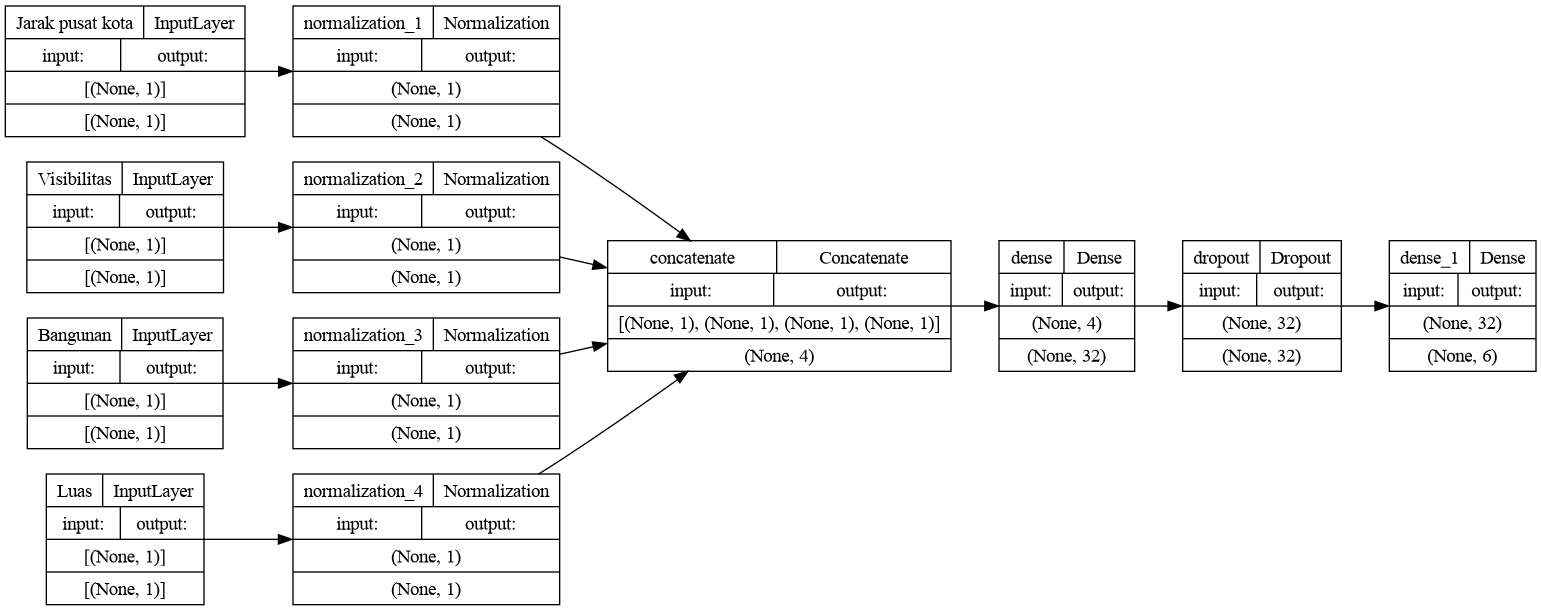

In [13]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [14]:
model.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100
32/32 [==============================] - 1s 13ms/step - loss: 1.9690 - accuracy: 0.1406 - val_loss: 1.7832 - val_accuracy: 0.1538
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 1.8311 - accuracy: 0.2031 - val_loss: 1.6838 - val_accuracy: 0.1538
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 1.7117 - accuracy: 0.2188 - val_loss: 1.5993 - val_accuracy: 0.3846
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 1.7007 - accuracy: 0.2734 - val_loss: 1.5245 - val_accuracy: 0.4615
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 1.5987 - accuracy: 0.2812 - val_loss: 1.4566 - val_accuracy: 0.4615
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 1.5201 - accuracy: 0.3750 - val_loss: 1.3916 - val_accuracy: 0.6923
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 1.4551 - accuracy: 0.4453 - val_loss: 1.3323 - val_accuracy: 0.6923
Epoch 8/100


Epoch 59/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5423 - accuracy: 0.8203 - val_loss: 0.4537 - val_accuracy: 0.9231
Epoch 60/100
32/32 [==============================] - 0s 4ms/step - loss: 0.5044 - accuracy: 0.8438 - val_loss: 0.4506 - val_accuracy: 0.9231
Epoch 61/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5067 - accuracy: 0.8750 - val_loss: 0.4452 - val_accuracy: 0.9231
Epoch 62/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5697 - accuracy: 0.7969 - val_loss: 0.4402 - val_accuracy: 0.9231
Epoch 63/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5427 - accuracy: 0.8594 - val_loss: 0.4348 - val_accuracy: 0.9231
Epoch 64/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5728 - accuracy: 0.8281 - val_loss: 0.4333 - val_accuracy: 0.9231
Epoch 65/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5046 - accuracy: 0.8594 - val_loss: 0.4295 - val_accuracy: 0.9231
Epoch 

Epoch 1/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4215 - accuracy: 0.8672 - val_loss: 0.3328 - val_accuracy: 0.9231
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3930 - accuracy: 0.8828 - val_loss: 0.3332 - val_accuracy: 0.9231
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4386 - accuracy: 0.8125 - val_loss: 0.3277 - val_accuracy: 0.9231
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4336 - accuracy: 0.8750 - val_loss: 0.3261 - val_accuracy: 0.9231
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3802 - accuracy: 0.9062 - val_loss: 0.3247 - val_accuracy: 0.9231
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3641 - accuracy: 0.8828 - val_loss: 0.3224 - val_accuracy: 0.9231
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4030 - accuracy: 0.8750 - val_loss: 0.3149 - val_accuracy: 0.9231
Epoch 8/100
3

Epoch 59/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3175 - accuracy: 0.8906 - val_loss: 0.2594 - val_accuracy: 0.9231
Epoch 60/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3275 - accuracy: 0.8828 - val_loss: 0.2586 - val_accuracy: 0.9231
Epoch 61/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3179 - accuracy: 0.8906 - val_loss: 0.2631 - val_accuracy: 0.9231
Epoch 62/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2664 - accuracy: 0.9375 - val_loss: 0.2616 - val_accuracy: 0.9231
Epoch 63/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3215 - accuracy: 0.8828 - val_loss: 0.2620 - val_accuracy: 0.9231
Epoch 64/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3515 - accuracy: 0.8906 - val_loss: 0.2620 - val_accuracy: 0.9231
Epoch 65/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3766 - accuracy: 0.8672 - val_loss: 0.2618 - val_accuracy: 0.9231
Epoch 

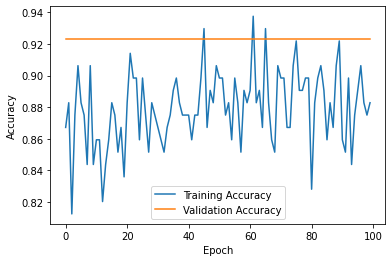

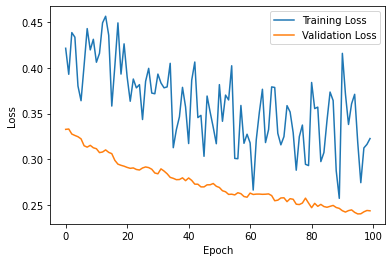

In [15]:
import matplotlib.pyplot as plt

history = model.fit(train_ds, epochs=100, validation_data=val_ds)

# Get the training and validation metrics from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
test

,Peruntukan,Jarak pusat kota,Visibilitas,Bangunan,Luas
0,4,1126,3,2,1192
1,4,2050,2,2,997
2,5,2327,3,2,14060
3,5,648,3,1,6025
4,0,3949,1,0,10390
5,0,1608,1,0,7745
6,0,4831,1,0,5700
7,1,2362,3,1,27024
8,1,2946,2,1,8740
9,3,2574,3,2,3614


In [17]:
model.predict(val_ds)

array([[-16.390764  ,  -4.7702675 , -14.2013445 ,   3.5451572 ,
          1.8538502 ,  -1.5111101 ],
       [-12.81572   ,  -5.4725657 , -14.487881  ,  -0.5017066 ,
          4.9125504 ,  -4.8407993 ],
       [-12.85166   ,  -1.4907821 , -11.839135  ,  -0.9890381 ,
          0.48564702,   2.1989992 ],
       [ -9.747307  ,  -0.43025827,  -3.1615634 ,  -1.382678  ,
         -4.1817513 ,   1.2788806 ],
       [  9.059599  ,  -0.7858168 , -10.248297  ,  -8.496129  ,
        -31.238918  , -23.438164  ],
       [  8.513666  ,  -1.2354478 , -10.137164  ,  -7.61579   ,
        -30.56967   , -22.97908   ],
       [  8.981979  ,  -1.0968117 , -10.211305  ,  -6.679423  ,
        -30.93388   , -23.938864  ],
       [ -7.453269  ,   2.0329106 ,  -2.287879  ,  -6.590109  ,
         -6.5051284 ,   0.53421307],
       [ -2.051196  ,   1.2451026 ,  -5.7288337 ,  -1.1083844 ,
         -5.895064  ,  -5.3580613 ],
       [-15.514087  ,  -4.1829047 , -13.759892  ,   2.8212721 ,
          1.5880103 ,  -0.8

In [18]:
import numpy as np

y_pred = model.predict(val_ds)

         #   test.Peruntukan == "Pasar",
          #   test.Peruntukan == "Kantor",
           #  test.Peruntukan == "Ruko",
            # test.Peruntukan == "Taman",
             #test.Peruntukan == "Perumahan",
             #test.Peruntukan == "Sawah",
            
         #   value = [5,4,3,2,1,0]
y_pred



array([[-16.390764  ,  -4.7702675 , -14.2013445 ,   3.5451572 ,
          1.8538502 ,  -1.5111101 ],
       [-12.81572   ,  -5.4725657 , -14.487881  ,  -0.5017066 ,
          4.9125504 ,  -4.8407993 ],
       [-12.85166   ,  -1.4907821 , -11.839135  ,  -0.9890381 ,
          0.48564702,   2.1989992 ],
       [ -9.747307  ,  -0.43025827,  -3.1615634 ,  -1.382678  ,
         -4.1817513 ,   1.2788806 ],
       [  9.059599  ,  -0.7858168 , -10.248297  ,  -8.496129  ,
        -31.238918  , -23.438164  ],
       [  8.513666  ,  -1.2354478 , -10.137164  ,  -7.61579   ,
        -30.56967   , -22.97908   ],
       [  8.981979  ,  -1.0968117 , -10.211305  ,  -6.679423  ,
        -30.93388   , -23.938864  ],
       [ -7.453269  ,   2.0329106 ,  -2.287879  ,  -6.590109  ,
         -6.5051284 ,   0.53421307],
       [ -2.051196  ,   1.2451026 ,  -5.7288337 ,  -1.1083844 ,
         -5.895064  ,  -5.3580613 ],
       [-15.514087  ,  -4.1829047 , -13.759892  ,   2.8212721 ,
          1.5880103 ,  -0.8

In [19]:
val_ds

<BatchDataset element_spec=({'Jarak pusat kota': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'Visibilitas': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'Bangunan': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'Luas': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
# Ubah output prediksi menjadi label kelas
label_kelas = ['Sawah', 'Perumahan', 'Taman', 'Ruko', 'Kantor', 'Pasar']
y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

# Tampilkan hasil prediksi
print(y_pred_label)

['Ruko', 'Kantor', 'Pasar', 'Pasar', 'Sawah', 'Sawah', 'Sawah', 'Perumahan', 'Perumahan', 'Ruko', 'Ruko', 'Ruko', 'Taman']


In [21]:
for x in y_pred_label:
    print(x)

Ruko
Kantor
Pasar
Pasar
Sawah
Sawah
Sawah
Perumahan
Perumahan
Ruko
Ruko
Ruko
Taman


In [22]:
test

,Peruntukan,Jarak pusat kota,Visibilitas,Bangunan,Luas
0,4,1126,3,2,1192
1,4,2050,2,2,997
2,5,2327,3,2,14060
3,5,648,3,1,6025
4,0,3949,1,0,10390
5,0,1608,1,0,7745
6,0,4831,1,0,5700
7,1,2362,3,1,27024
8,1,2946,2,1,8740
9,3,2574,3,2,3614


In [23]:
 [ -3.4406643 ,  -0.51060563,  -4.1595945 ,   2.022017  ,
         -0.9544041 ,  -2.0240772 ]

[-3.4406643, -0.51060563, -4.1595945, 2.022017, -0.9544041, -2.0240772]

In [24]:
['Sawah', 'Perumahan', 'Taman', 'Ruko', 'Kantor', 'Pasar']

['Sawah', 'Perumahan', 'Taman', 'Ruko', 'Kantor', 'Pasar']